# COMP 4254 Advanced Topics in Data Analytics - Final Project
#  Time-series Forecasting with ARIMA Model
##  Forecasting Crime in Vancouver
### March, 29 2018
### By Wilian Osaku
---

# Introduction
---
This is the final project for the course COMP 4254 Advanced Topics in Data Analytics, instructor Burak Yoldemir, at the British Columbia Institute of Technology.

Sections of this Project:

1. Problem Statement
2. Processing the data
3. Data Transformation
4. Exploratory Data Analysis
5. The ARIMA Model
6. Conclusion

<br>
# 1. Problem Statement
---
Many data analysis projects, especially in the business environment, are time-series related. Predicting numbers such as sales, website visitors, data traffic, diseases, etc, is something that can be of a great value to organizations. 

In this project, I'll be forecasting the number of crimes in Vancouver, using a statistical model called ARIMA (Auto-Regressive Integrated Moving Average). For this specific case, forecasting the number of crime can help the Vancouver Police Department to take preventive measures and anticipate possible criminal activities.

<br>

# 2. Processing the data
---

## The Data set
The data comes from the <a href="http://data.vancouver.ca/datacatalogue/crime-data.htm
" target="_blank">Vancouver Open Data Catalogue</a>. 

It was extracted on 2018-03-22 and it contains 557,103 records from 2003-01-01 to 2018-03-15.

In [1]:
# Import data manipulation packages
import numpy as np
import pandas as pd
import itertools

# Import data visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

# Import statistical packages
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm #version >0.8 required

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import CSV file as a pandas df (Data Frame)
df = pd.read_csv('crime_csv_all_years.csv')

In [3]:
# Take a look at the first entries
df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Offence Against a Person,2003,6,6,NaN,NaN,OFFSET TO PROTECT PRIVACY,NaN,0.00,0.00
1,Offence Against a Person,2003,5,7,NaN,NaN,OFFSET TO PROTECT PRIVACY,NaN,0.00,0.00
2,Mischief,2003,3,28,1.0,0.0,5X E CORDOVA ST,Central Business District,492492.10,5458853.64
3,Mischief,2003,12,12,19.0,30.0,38XX W 21ST AVE,Dunbar-Southlands,486149.90,5455681.38
4,Mischief,2003,7,8,23.0,0.0,38XX W 21ST AVE,Dunbar-Southlands,486131.41,5455690.70


In [4]:
# Check the Types of crimes and the count
df['TYPE'].value_counts()

Theft from Vehicle                                        182614
Mischief                                                   74360
Break and Enter Residential/Other                          62572
Offence Against a Person                                   56348
Other Theft                                                55892
Theft of Vehicle                                           39363
Break and Enter Commercial                                 35373
Theft of Bicycle                                           27121
Vehicle Collision or Pedestrian Struck (with Injury)       22963
Vehicle Collision or Pedestrian Struck (with Fatality)       265
Homicide                                                     232
Name: TYPE, dtype: int64

### Removing certain types

For this analysis, I'm interested in crimes like Theft and Break and Enter. Therefore, I'm excluding **Vehicle Collision** related types and **homicide**.

In [5]:
df = df[(df['TYPE'] != 'Vehicle Collision or Pedestrian Struck (with Injury)')]
df = df[(df['TYPE'] != 'Vehicle Collision or Pedestrian Struck (with Fatality)')]
df = df[(df['TYPE'] != 'Homicide')]

### Creating the DATE index
The date is separated in different columns (YEAR, MONTH, DAY) , I'll combine them into a single column and add it as a new column called 'DATE'

In [6]:
# Pandas function to_datetime to convert it to a datetime data type
df['DATE'] = pd.to_datetime({'year':df['YEAR'], 'month':df['MONTH'], 'day':df['DAY']})

In [7]:
# Changing the index to the colum 'DATE', sorting index by date, checking info
df.index = pd.DatetimeIndex(df['DATE'])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 533643 entries, 2003-01-01 to 2018-03-15
Data columns (total 11 columns):
TYPE             533643 non-null object
YEAR             533643 non-null int64
MONTH            533643 non-null int64
DAY              533643 non-null int64
HOUR             477295 non-null float64
MINUTE           477295 non-null float64
HUNDRED_BLOCK    533630 non-null object
NEIGHBOURHOOD    474986 non-null object
X                533643 non-null float64
Y                533643 non-null float64
DATE             533643 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 48.9+ MB


This dataset was extracted in 2018-03-22 and it contains partial data for Mar-2018. I'm excluding them to keep full months only.

In [8]:
# Filtering the data to exclude month of March 18
df = df[df['DATE'] < '2018-03-01']

In [9]:
# Checking the data again
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 532313 entries, 2003-01-01 to 2018-02-28
Data columns (total 11 columns):
TYPE             532313 non-null object
YEAR             532313 non-null int64
MONTH            532313 non-null int64
DAY              532313 non-null int64
HOUR             476077 non-null float64
MINUTE           476077 non-null float64
HUNDRED_BLOCK    532300 non-null object
NEIGHBOURHOOD    473770 non-null object
X                532313 non-null float64
Y                532313 non-null float64
DATE             532313 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 48.7+ MB


# 3. Data Transformation
---
In the original data, each instance is an individual crime. There are also features related to the date and time of the crime and to the location.

For this project, I want to forecast the monthly number of crime per type. In order to do that, I need to transform the data. The only features that will be used are the date (the index of the data frame) and the type.

In [10]:
# Create a new dataframe with the count of 'Theft from Vehicle' by month
monthly = pd.DataFrame(df[df['TYPE']=='Theft from Vehicle'].resample('M').size())
monthly.columns = ['Theft from Vehicle']

# Repeat for the other types
for i in df['TYPE'].unique():
    monthly[i] = pd.DataFrame(df[df['TYPE']==i].resample('M').size()) 

# Create a total
monthly['Total'] = monthly.sum(axis=1)

# Create a list of the types
crimeTypes = monthly.columns

In [11]:
# Take a look on the first entries
monthly.head()

,Theft from Vehicle,Offence Against a Person,Mischief,Theft of Vehicle,Other Theft,Break and Enter Commercial,Break and Enter Residential/Other,Theft of Bicycle,Total
DATE,,,,,,,,,
2003-01-31,1438,344,551,640,247,303,644,96,4263
2003-02-28,1102,280,484,528,219,254,507,71,3445
2003-03-31,1251,314,575,569,208,292,515,76,3800
2003-04-30,1528,239,621,476,235,266,608,97,4070
2003-05-31,1873,288,590,541,223,291,565,114,4485


In [12]:
# Check the new dataframe
monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182 entries, 2003-01-31 to 2018-02-28
Freq: M
Data columns (total 9 columns):
Theft from Vehicle                   182 non-null int64
Offence Against a Person             182 non-null int64
Mischief                             182 non-null int64
Theft of Vehicle                     182 non-null int64
Other Theft                          182 non-null int64
Break and Enter Commercial           182 non-null int64
Break and Enter Residential/Other    182 non-null int64
Theft of Bicycle                     182 non-null int64
Total                                182 non-null int64
dtypes: int64(9)
memory usage: 14.2 KB


The monthly data contains **182 months and 9 types** (including 'Total') and all types contain non-null values.

Now I have a data frame called __*monthly*__ that is going to be used in this project.

# 4. Exploratory Data Analysis
---
### How many crimes per month?
Since this is a time-series, I'll start by plotting the number of crimes by month.

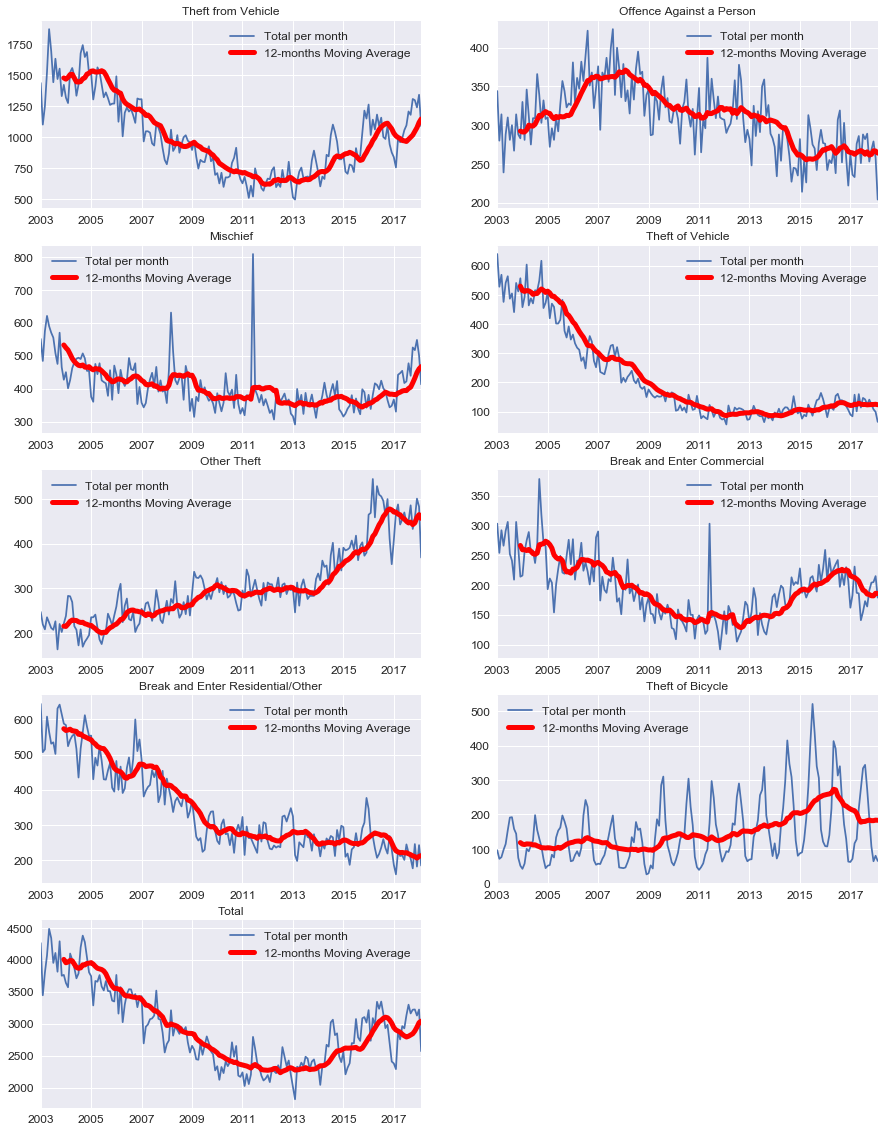

In [13]:
# Initiate the figure and define size
plt.figure(1)
plt.figure(figsize=(15,20))

# Using a for loop to plot each type of crime with a 12 months-moving average
i = 521
for eachCrime in crimeTypes:    
    plt.subplot(i);
    monthly[eachCrime].plot(label='Total per month')
    monthly[eachCrime].rolling(window=12).mean().plot(color='red', linewidth=5, label='12-months Moving Average')
    plt.title(eachCrime, fontsize=12)
    plt.xlabel('')
    plt.legend(prop={'size':12})
    plt.tick_params(labelsize=12)
    i = i + 1

### Key Findings
* First, we can see clearly that there is a __*trend*__ for all types. This indicates that the data is __*non-stationary*__.

By type:
* "Theft from Vehicle":
  * It is the most frequent type.
  * It decreased along with "Theft of Vehicle" until 2012, but then it increased significantly.
  
  
* "Theft of Vehicle:
  * It had a major decrease, from an above 500 crimes per month in 2003 to around 100 in 2012. That's impressive!
  * Although the average has been increasing in the past years, it's way below 2003.
  * In 2002, the "Bait Car" program was launched and in 2003 the IMPACT group was formed. It looks like they've been doing a great job!
  
  
* "Other Theft":
  * Other theft has been increasing, from around 200 to almost 500 crimes per month. Could it be because Theft of Vehicle  became too risky, but thieves still need to "make a living"? 
 
  
* "Mischief" and "Break and Enter Commercial":
  * There is a huge peak 2011. This was the Stanley Cup Riot that happened on June 06 of 2011. It was the Stanley Cup's final game, Boston Bruins vs Vancouver Canucks. There were 155,000 people watching it in the downtown area. Before the game was over, as the Vancouver Canucks was about to lose it, a big riot started. The result can be seen in those visualizations.


* "Theft of Bicycle":
  * We can see a clear seasonality within the year. It has peaks during summer months, which is expected.
  * The average has also been increasing.


* "Total":
  * In total, the number of crime (of types considered in this project), decreased significantly from 2003 to 2014, when it started increasing and came back to the level of 2008.



# 5. The ARIMA Model
---

The ARIMA is a forecasting model that uses a regression of previous lagged values and a combination of error terms to predict a future value. The ARIMA model is normally used when the data is non-stationary, and to transform it to a stationary data, it calculates the difference of the value with a previous value.

The representation of the ARIMA model is ARIMA(p,d,q), in which:
* _p_ is the order of the lagged values to be regressed, related to the AR (Auto-Regressive)
* _d_ is the order of the difference needed to transform it to a stationary data, related to the I (Integrated)
* _q_ is the order of the forecast errors, related to the MA (Moving-Average)


## Methodology

Two different approaches can be used to find the best parameters (p,d,q) for the model:
1. **The Statistical approach**: this method requires the analysis of statistical tests and functions to determine which parameters to use. This approach can result in a better model by fine-tuning the parameters. On the other hand, it requires statistical knowledge that many analysts do not have.

2. **The "Machine Learning" approach**: this method is based on machine learning techniques such as grid search/brute force. To find the best parameters, we'll choose a "cost function" and run different combinations of parameters. The combination that results in the lower "cost" will be then defined as the "best" parameter. While this can lead to imprecise or maybe not the actual best parameters, it has the advantage of achieving results without statistical knowledge by automating the process.


As I'm not a statistician, I'll use the Statistical Approach first for one type of crime as a learning procedure. But the main approach will be the Machine Learning Approach. 


## Statistical Approach

According to professor Robert Nau from Duke University <a href="https://people.duke.edu/~rnau/Slides_on_ARIMA_models--Robert_Nau.pdf">(source)</a>, the steps of a construction of an ARIMA MODEL are:
```
1. Stationarize the series, if necessary, by differencing (& perhaps also logging, deflating, etc.)
2. Study the pattern of autocorrelations and partial autocorrelations to determine if lags of the stationarized series and/or lags of the forecast errors should be included in the forecasting equation
3. Fit the model that is suggested and check its residual diagnostics, particularly the residual ACF and PACF plots, to see if all coefficients are significant and all of the pattern has been explained.
4. Patterns that remain in the ACF and PACF may suggest the need for additional AR or MA terms
```

#### 1. Stationarize the Series
As seen in the time-series plot, the data is non-stationary. In order to make it stationary, usually doing the first difference (example: Yt - Yt-1) is enough.

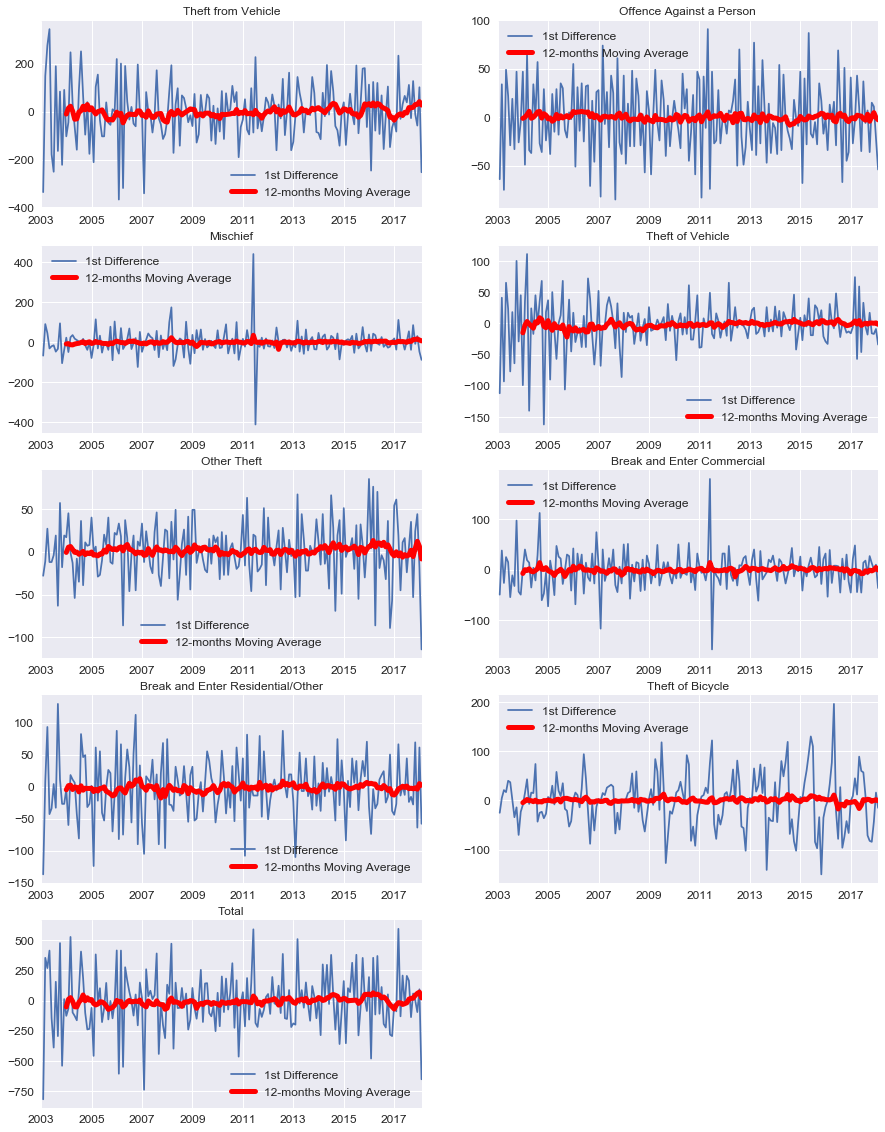

In [14]:
# Initiate the figure and define size
plt.figure(1)
plt.figure(figsize=(15,20))

# Using a for loop to plot each type of crime with a moving average
i = 521
for eachCrime in crimeTypes:    
    plt.subplot(i);
    monthly[eachCrime].diff().plot(label='1st Difference')
    monthly[eachCrime].rolling(window=12).mean().diff().plot(color='red', linewidth=5, label='12-months Moving Average')
    plt.title(eachCrime, fontsize=12)
    plt.xlabel('')
    plt.legend(prop={'size':12})
    plt.tick_params(labelsize=12)
    i = i + 1

By looking at the plot of the first difference, it seems that the data actually became stationary (the moving average is around 0). 

Another way to test if the data is stationary is to use the **Augmented Dickey–Fuller test (ADF statistic)**.

The hypothesis test:
* The null hypothesis is that a unit root is present in a time series.
* The alternative hypothesis is that the data is stationary.

In [15]:
# Create a data frame with the 1st difference
montlhy_1stDiff = monthly.diff().dropna()

# Create a data frame with the results of the ADF test for each type
adfullerResults = pd.DataFrame(columns=crimeTypes, index = ['ADF','Critical Value 1%','Critical Value 5%','p-value'])
for eachType in crimeTypes:
    adf = adfuller(montlhy_1stDiff[eachType])
    adfullerResults[eachType] = ("{:.4f}".format(adf[0]),                                 
                                 "{:.4f}".format(adf[4]['1%']),
                                 "{:.4f}".format(adf[4]['5%']),
                                 "{:.4f}".format(adf[1]),)                                
adfullerResults                                

,Theft from Vehicle,Offence Against a Person,Mischief,Theft of Vehicle,Other Theft,Break and Enter Commercial,Break and Enter Residential/Other,Theft of Bicycle,Total
ADF,-9.7861,-5.7968,-7.8365,-4.9766,-7.2662,-10.9287,-7.2560,-9.9283,-3.5705
Critical Value 1%,-3.4678,-3.4696,-3.4685,-3.4692,-3.4690,-3.4678,-3.4694,-3.4694,-3.4704
Critical Value 5%,-2.8780,-2.8788,-2.8783,-2.8786,-2.8785,-2.8780,-2.8787,-2.8787,-2.8791
p-value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0064


For all types the p-value is very small, so we can reject the null hypothesis and conclude that the first difference of the data is stationary.

#### 2. Autocorrelation and Partial Autocorrelations

The second step of this approach is to "study the pattern of autocorrelations and partial autocorrelations to determine if lags of the stationarized series and/or lags of the forecast errors should be included in the forecasting equation". To do that, we can plot the Autocorrelation (ACF) and the Partial autocorrelation (PACF).

Theft from Vehicle


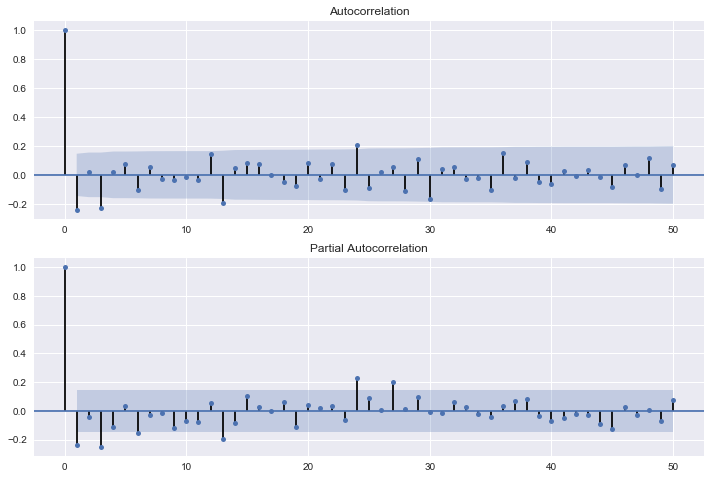

In [16]:
print(montlhy_1stDiff[crimeTypes[0]].name)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(montlhy_1stDiff[crimeTypes[0]], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(montlhy_1stDiff[crimeTypes[0]], lags=50, ax=ax2)

Since the ACF shows a negative value for lag 1 and the ACF has a sharp cut, it appears that the model show have a MA term. A deeper study of these plots should be done to follow with this approach. However, as it requires statistical knowledge and it is time-consuming to do for each type of crime, I'll be using the automated approach.

<br>
## The "Machine Learning" Approach

In order to find the best parameters for each crime type, I'll be testing different combinations of (p,d,q). To assess the quality of the model, the _Akaike Information Criterion (AIC)_ will be used as a "cost" function. The model that results in the lowest AIC will be selected as the best model.

To fit the model, I'll be using the "Statsmodel" package that has an implementation of the ARIMA. To be more specific, the model is the SARIMAX, where the S stands for Seasonal and the X for exogenous. 


In [17]:
# First, I'm creating a list of combinations of p,d,q
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [18]:
# Creating a function to use a pipeline
def myArima(crimeTypeSeries):
    '''
    Takes in a series, returns the result of the model.
    Steps:
    1 - Find the best parameters
    2 - Train the model
    3 - Plot diagnostics
    4 - Plot forecast
    '''
    
    print ('Training for:', crimeTypeSeries.name)
    
    # 1 - Find the best parameters for P, D, Q
    lowestAIC = 999999999
    bestOrder = 0
    bestSeasonal_order = 0
    i = 0 # progress indicator
    
    for param in pdq:    
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(crimeTypeSeries,
                                                order=param,
                                                seasonal_order=param_seasonal)
                results = mod.fit()                
                
                # Keep the parameters that gives the lowest AIC
                newAIC = results.aic                
                if newAIC < lowestAIC: 
                    lowestAIC = newAIC
                    bestOrder = param
                    bestSeasonal_order = param_seasonal
                i = i+1
                print('\r', 'Calculating: {:.0f}%'.format(i/64*100), end='')
                
            except:
                i = i+1
                print('\r', 'Calculating: {:.0f}%'.format(i/64*100), end='')
                continue
      
    # 2 - Train the model with the best parameters
    print('\nBest parameters: SARIMA{}x{}12'.format(param, param_seasonal))
    mod = sm.tsa.statespace.SARIMAX(crimeTypeSeries, 
                                    order=bestOrder, 
                                    seasonal_order=bestSeasonal_order)
    results = mod.fit()

    # Plot diagnostics
    results.plot_diagnostics(figsize=(15, 12))    
    plt.show()
    
    # Plot Forecast
    pred = results.get_prediction(start = 145, end = 181, dynamic=False)
    pred_ci = pred.conf_int()
    pred_ci.head()
    plt.figure(figsize=(15,6))
    ax = crimeTypeSeries.plot(label='observed')
    plt.title("Actual and Forecast", fontsize=12)
    pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', color='red', alpha=.7, lw=4)
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='r', alpha=.3)    
    ax.set_xlabel('Years')
    ax.set_ylabel('Number of crime')   
    plt.legend()
    plt.show()
    return results

Now let's use the function with each type of crime to have a forecast. 

Training for: Theft from Vehicle
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


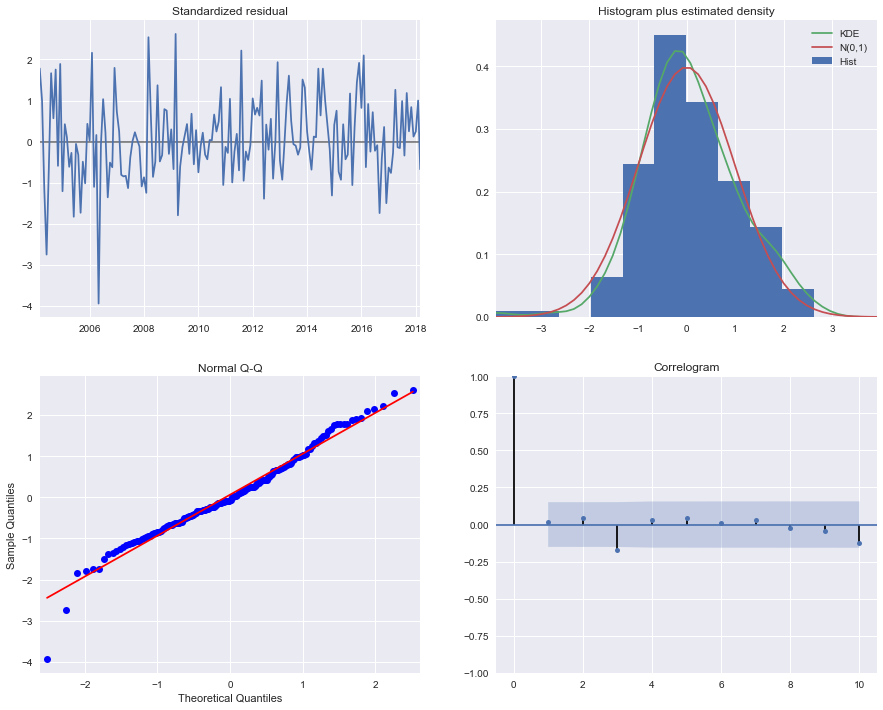

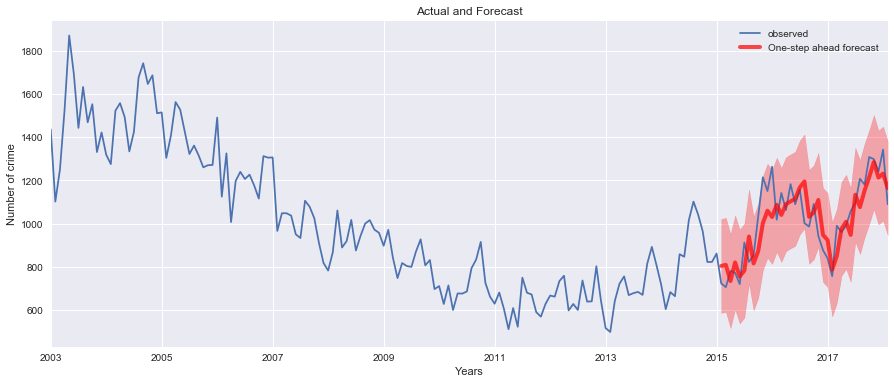

Training for: Offence Against a Person
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


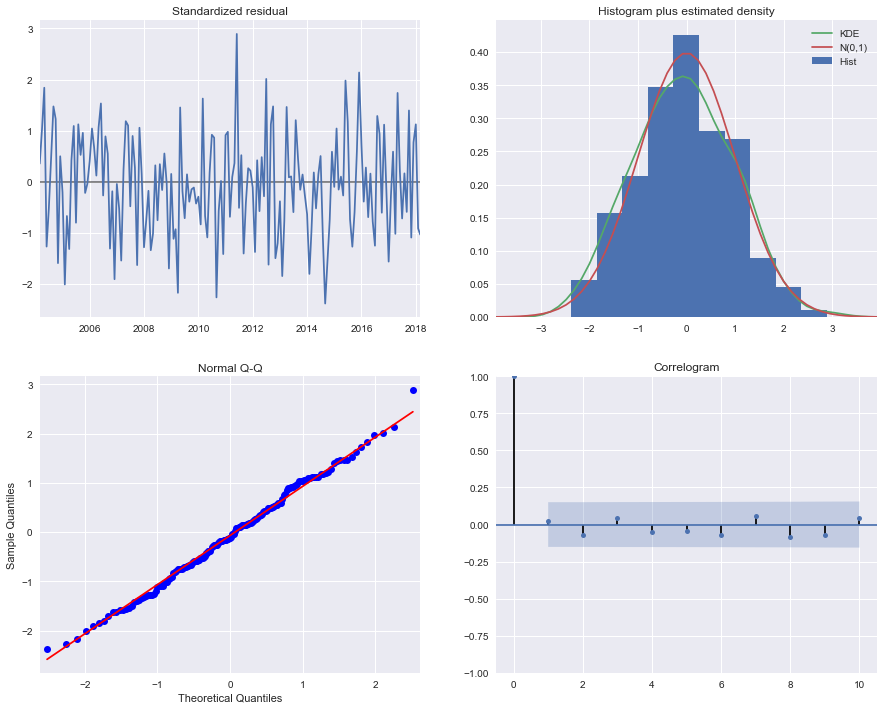

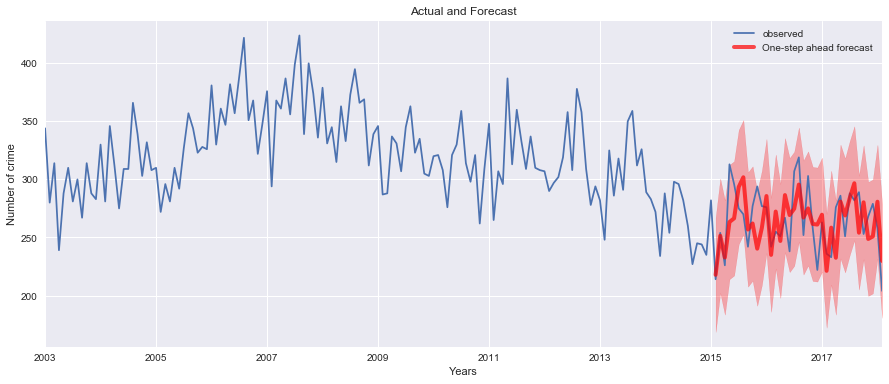

Training for: Mischief
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


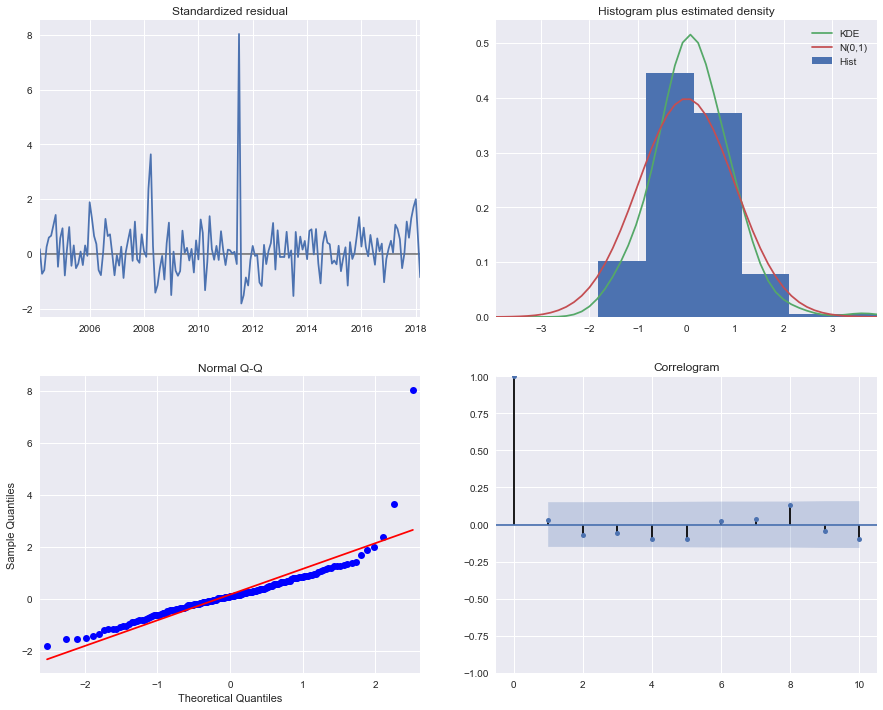

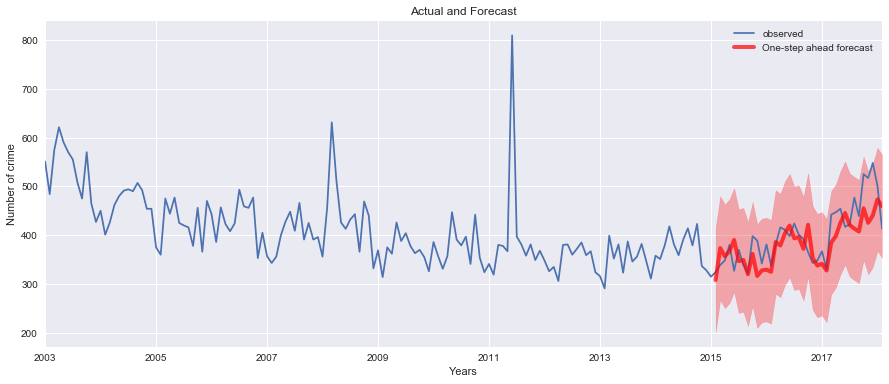

Training for: Theft of Vehicle
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


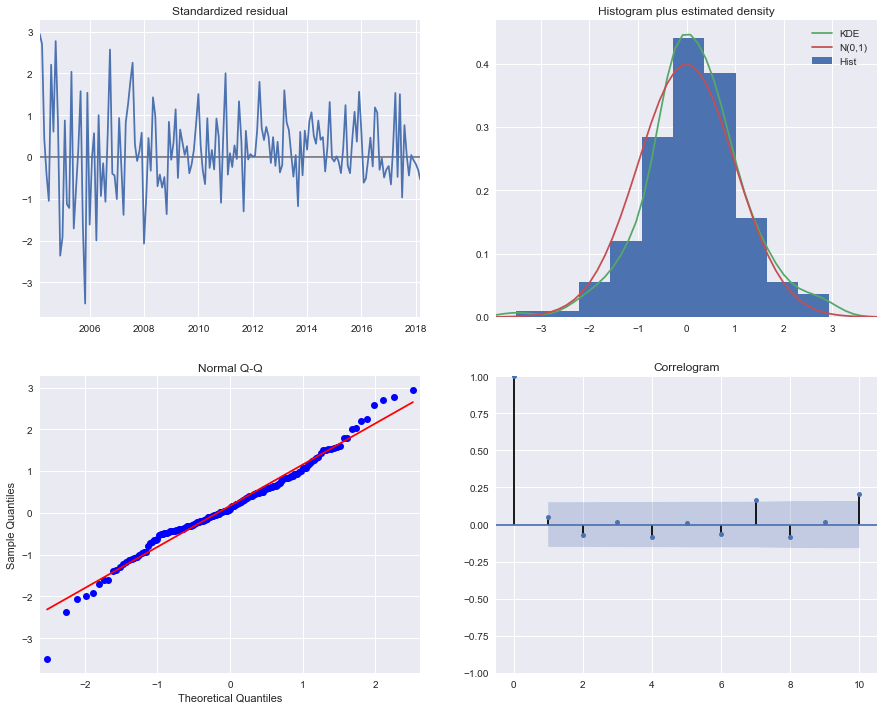

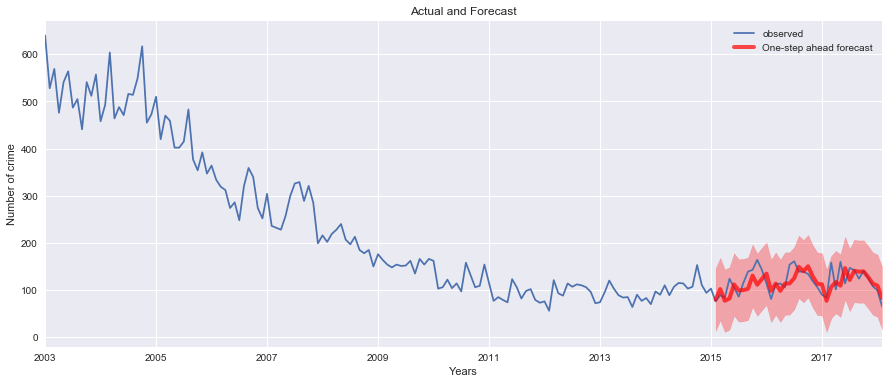

Training for: Other Theft
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


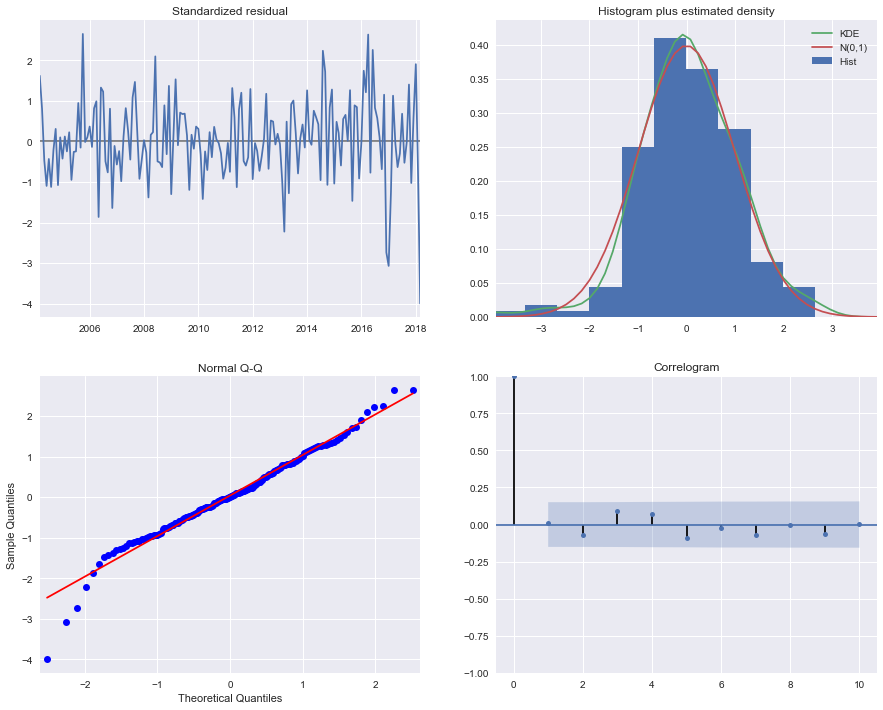

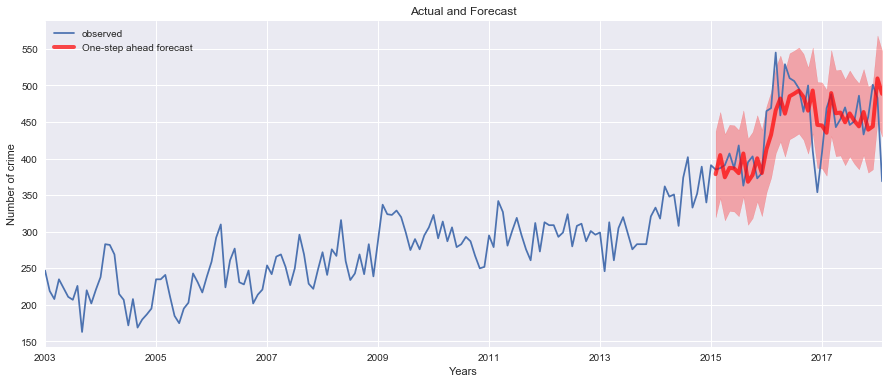

Training for: Break and Enter Commercial
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


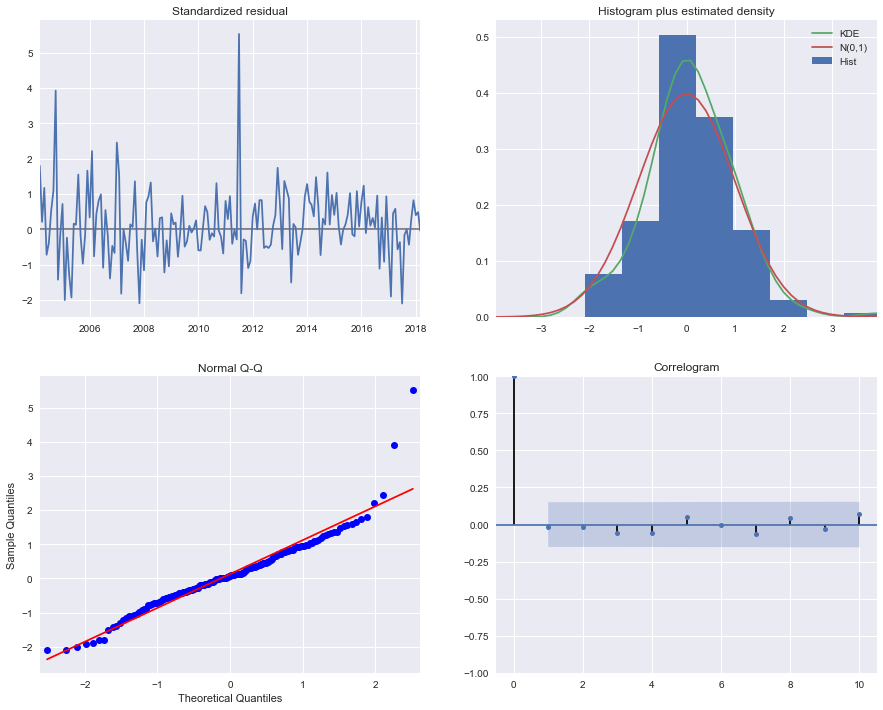

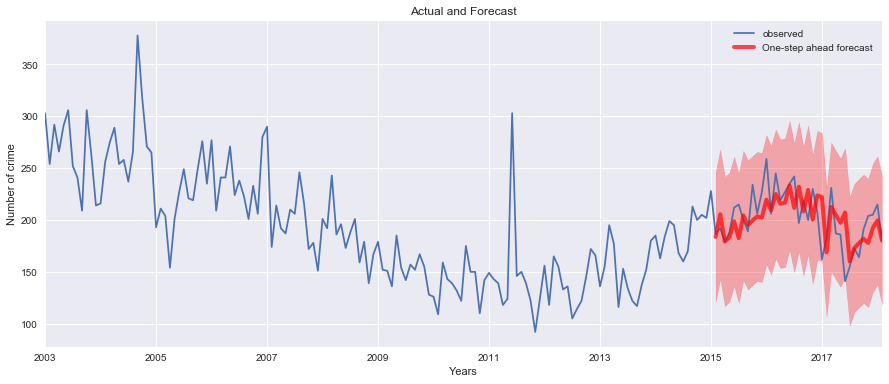

Training for: Break and Enter Residential/Other
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


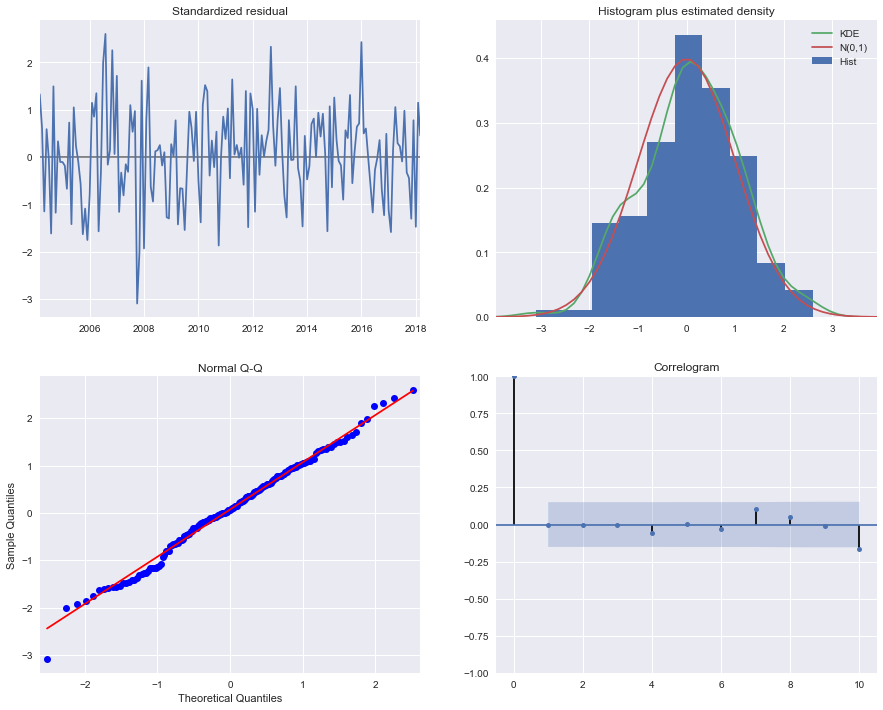

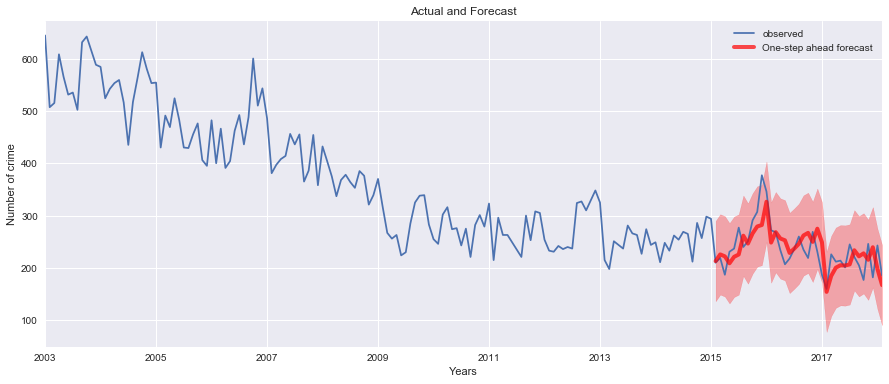

Training for: Theft of Bicycle
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


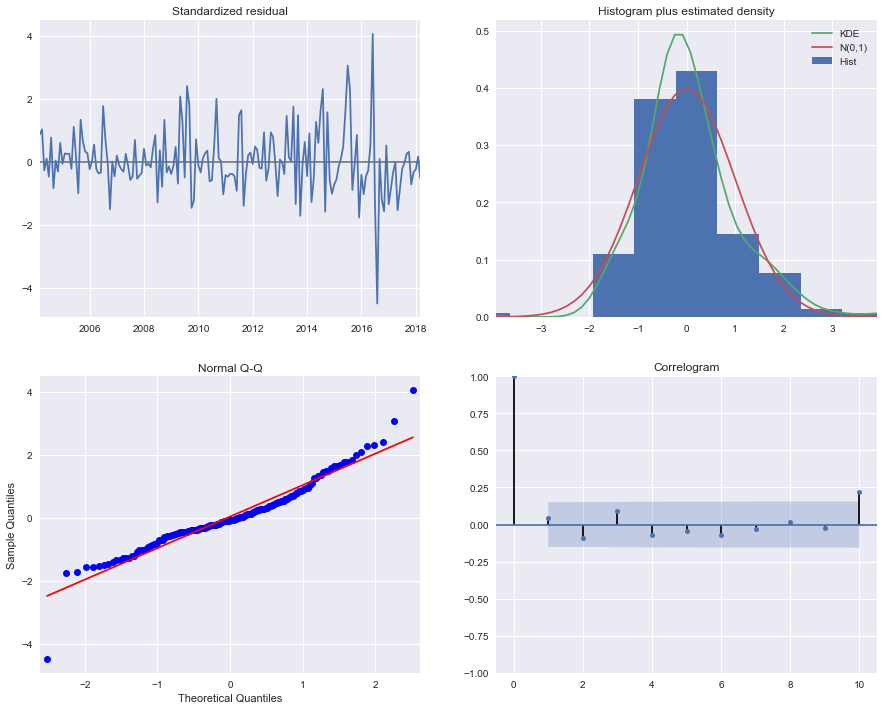

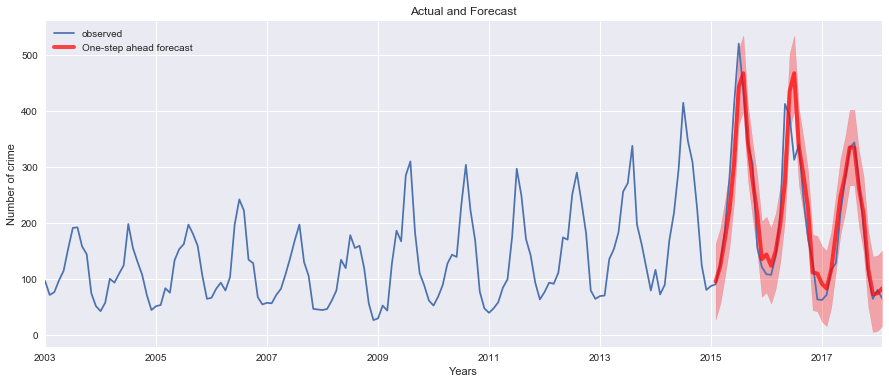

Training for: Total
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


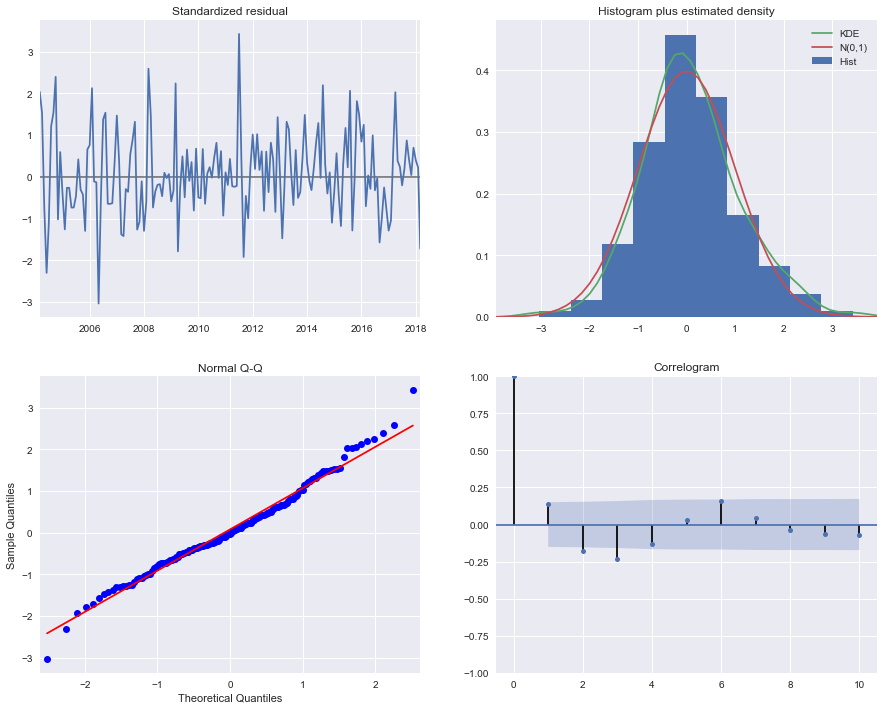

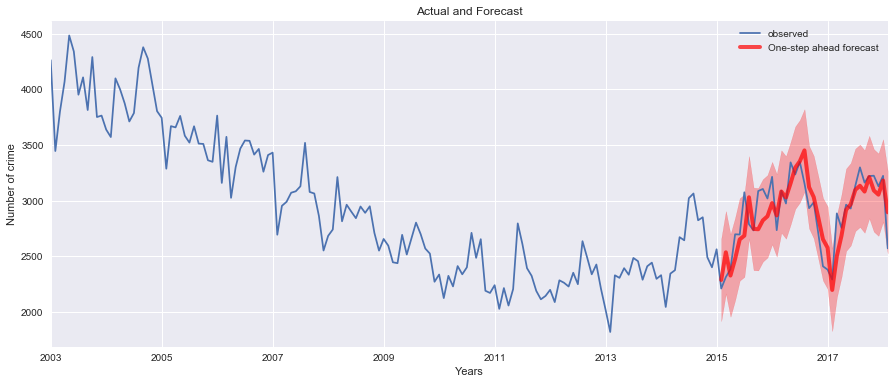

In [19]:
# First, initialize an empty array to store all results, loop through each type of crime
results = []
for i in crimeTypes:    
    results.append(myArima(monthly[i]))

Now let's calculate a measue of error, in this case the *Mean Absolute Percentage Error (MAPE)*.

In [20]:
# Get the predicted value for the years 2017 and 2018 
predictions = []
for i in range(0,len(results)):
    predictions.append(results[i].get_prediction(start = 168, end = 189, dynamic=False).predicted_mean)

In [21]:
# Calculate the error
predictions = pd.DataFrame(predictions)
predictions = predictions.transpose()
predictions.columns = monthly.columns
errors = ((monthly - predictions)/monthly)
errors.dropna(how='all', inplace=True)
n = len(errors)

# Calculate the MAPE
MAPE = round((errors.abs().sum() / n)*100,2)
print ('The Mean Absolute Percentage Error for each type for the year 01/2017 to 02/2018')
print (MAPE)

The Mean Absolute Percentage Error for each type for the year 01/2017 to 02/2018
Theft from Vehicle                    6.03
Offence Against a Person              8.04
Mischief                              9.49
Theft of Vehicle                     15.58
Other Theft                           7.13
Break and Enter Commercial           11.33
Break and Enter Residential/Other    14.06
Theft of Bicycle                     14.24
Total                                 4.33
dtype: float64


When forecasting individual types, the MAPE ranges from 6% to 15.5%. When forecasting for the total number of crimes, the MAPE is 4.33%.

Next step is to get the Confidence Interval of the forecast.

In [22]:
# Get the predicted Confidence Interval for the years 2017 and 2018 
predictions_ci = []
for i in range(0,len(results)):
    predictions_ci.append(results[i].get_prediction(start = 168, end = 189, dynamic=False).conf_int())

Finally, I'm creating a function to display the forecasted value and confidence interval for each type for a specific month.

In [23]:
# Creating a function to display the forecasted value and confidence interval for a month
def forecastMonth(year_month):
    '''
    Takes in a year in the format 'yyyy-mm' (ie: '2018-03').
    Display the forecast for each type
    '''
    for i in range(0,9):
        pred_df = round(predictions.iloc[:,i:i+1][year_month],0)
        ci_df = round(predictions_ci[i][year_month],0)        
        ci_df.columns = ['Lower CI', 'Upper CI']
        frames = (pred_df,ci_df)
        display(pd.concat(frames, axis =1))

In [24]:
forecastMonth('2018-03')

,Theft from Vehicle,Lower CI,Upper CI
2018-03-31,1181.0,963.0,1399.0


,Offence Against a Person,Lower CI,Upper CI
2018-03-31,252.0,203.0,301.0


,Mischief,Lower CI,Upper CI
2018-03-31,506.0,400.0,611.0


,Theft of Vehicle,Lower CI,Upper CI
2018-03-31,108.0,42.0,174.0


,Other Theft,Lower CI,Upper CI
2018-03-31,455.0,397.0,514.0


,Break and Enter Commercial,Lower CI,Upper CI
2018-03-31,204.0,142.0,266.0


,Break and Enter Residential/Other,Lower CI,Upper CI
2018-03-31,194.0,118.0,271.0


,Theft of Bicycle,Lower CI,Upper CI
2018-03-31,105.0,38.0,173.0


,Total,Lower CI,Upper CI
2018-03-31,2994.0,2624.0,3365.0


# 6. Conclusion
---
In this project, I explored how to do a time-series forecast with ARIMA model. The forecast target was the number of crimes in Vancouver, by type of crime and by the total number of crimes. 

Although the dataset was related to crime, the same methodology is applicable to other datasets. By creating an automated pipeline that takes in a time-series, find the best model parameters and run a forecast, we can use it with other time-series. This approach can be extended to other business situations such as to forecast sales by product or store.

A challenge related to this approach is that by using automated parameters without a deeper study of them, we may not be using the actual best parameters. In this project, I used all the combinations of 0 and 1, but other values might have given a better result. To overcome this challenge, a better understanding of the impact of each parameter is necessary.

Considering that the model for the total number of crimes had a MAPE (Mean Absolute Percentage Error) of 4.3% and that the forecasts also captured the trends for each type of crime, the results can be considered satisfactory. 





---

Resources:

Robert Nau. Statistical forecasting: notes on regression and time series analysis.
https://people.duke.edu/~rnau/411home.htm

Statsmodel.
http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

Some notebooks used as references:

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima